In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import os
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
import random
import torchvision.utils as vutils
from glob import glob

In [ ]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

my_seed = 42
my_seed_everywhere(my_seed)

In [ ]:
data_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),                          
            transforms.ToTensor(), 
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [ ]:
trainset = dset.ImageFolder(root = '/content/drive/MyDrive/URP/train_300', 
                            transform=data_transforms)
testset = dset.ImageFolder(root = '/content/drive/Shareddrives/SKKU-URP-GAN/all/test', 
                           transform=data_transforms)

data_size = len(trainset.samples)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)
batch_size = 8
train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=batch_size,
                                           sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(trainset,
                                         batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=batch_size)

In [ ]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')


using device: cuda


In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f"Average loss: {ave_loss}, \
              Train accuracy: {train_accuracy}, \
              Val accuracy: {val_accuracy}")
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader, auc=False):
    model.eval() 
    correct_samples = 0
    total_samples = 0
    y_true, y_pred = [], []
    for (x, y) in loader:
      
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    
        indices = torch.argmax(prediction, 1)
        fpr, tpr, _ = roc_curve(y_gpu.cpu().detach().numpy(), indices.cpu().detach().numpy())

        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        accuracy = float(correct_samples) / total_samples
        torch.cuda.get_device_name(0)
        if auc:
            y_true.extend(y_gpu.cpu().detach().numpy())
            y_pred.extend(indices.cpu().detach().numpy())
    if auc:
        return accuracy, y_true, y_pred
    else: 
        return accuracy
    
    

    return accuracy, y_true, y_pred

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 9))
    plt.subplot(311)
#     plt.ylim(bottom=0)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(312)
    plt.ylim((.5, 1))
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")

    plt.legend();

In [ ]:
device = torch.device('cuda')
# torch.set_num_threads(16)
print(torch.cuda.get_device_name(0))
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(24),    
            Flattener(),
            nn.Linear(64*2*2, 2),
          )
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
nn_model.type(torch.cuda.FloatTensor)

nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, 
                       betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=0.0001, amsgrad=False)

Tesla P100-PCIE-16GB


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Average loss: 0.3468189239501953,               Train accuracy: 0.8345971563981043,               Val accuracy: 0.8861480075901328
Average loss: 0.2568662464618683,               Train accuracy: 0.8872037914691943,               Val accuracy: 0.8937381404174574
Average loss: 0.22499434649944305,               Train accuracy: 0.8971563981042654,               Val accuracy: 0.9108159392789373
Average loss: 0.198311448097229,               Train accuracy: 0.9137440758293839,               Val accuracy: 0.9013282732447818


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Average loss: 0.1898801624774933,               Train accuracy: 0.9151658767772511,               Val accuracy: 0.9297912713472486
Average loss: 0.18292538821697235,               Train accuracy: 0.9165876777251185,               Val accuracy: 0.9259962049335864
Average loss: 0.1666007936000824,               Train accuracy: 0.9218009478672986,               Val accuracy: 0.9354838709677419


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Average loss: 0.15559500455856323,               Train accuracy: 0.9317535545023696,               Val accuracy: 0.9259962049335864
Average loss: 0.15294897556304932,               Train accuracy: 0.9322274881516588,               Val accuracy: 0.9297912713472486
Average loss: 0.13515394926071167,               Train accuracy: 0.9388625592417061,               Val accuracy: 0.9259962049335864
Average loss: 0.13116033375263214,               Train accuracy: 0.9450236966824644,               Val accuracy: 0.9240986717267552
Average loss: 0.12592682242393494,               Train accuracy: 0.9459715639810427,               Val accuracy: 0.937381404174573
Average loss: 0.11238299310207367,               Train accuracy: 0.9535545023696682,               Val accuracy: 0.9411764705882353
Average loss: 0.1082206591963768,               Train accuracy: 0.9511848341232227,               Val accuracy: 0.9316888045540797
Average loss: 0.10704647749662399,               Train accuracy: 0.95545023696

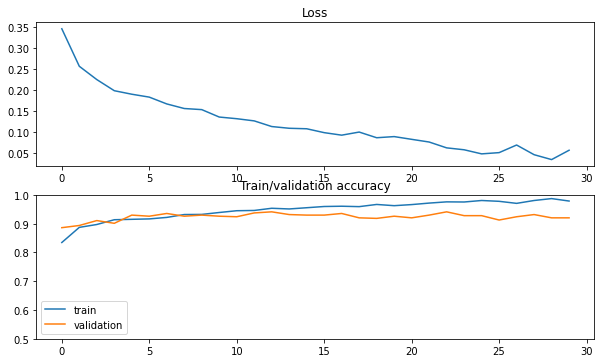

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 30)
loss_accuracy_plot(loss_history, train_history, val_history)
print('Finished!')

test_accuracy, y_true, y_pred = compute_accuracy(nn_model, test_loader, auc=True)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_rate = auc(fpr, tpr)


print(f'Final accuracy on the test set is: {test_accuracy}; auc is: {auc_rate}')

In [ ]:
test_accuracy, y_true, y_pred = compute_accuracy(nn_model, test_loader, auc=True)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_rate = auc(fpr, tpr)


print(f'Final accuracy on the test set is: {test_accuracy}; auc is: {auc_rate}')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Final accuracy on the test set is: 0.6787878787878788; auc is: 0.6491666666666667


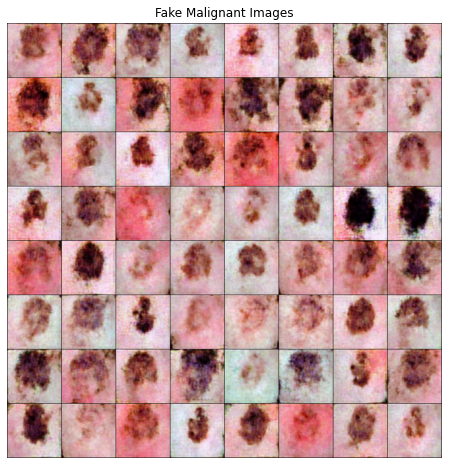


Number of Training images: 947


In [ ]:
dataroot = '/content/drive/Shareddrives/SKKU-URP-GAN/all/lig/mal'

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Malignant Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Print Num of Training dataset
training_images = glob(dataroot + '/*/*.jpg')
print("\nNumber of Training images:", len(training_images))